# Nuts and Bolts of `se3cnn`

## tutorial by: Tess E. Smidt
## code by: 

[![DOI](https://zenodo.org/badge/116704656.svg)](https://zenodo.org/badge/latestdoi/116704656)
```
@misc{mario_geiger_2019_3348277,
  author       = {Mario Geiger and
                  Tess Smidt and
                  Wouter Boomsma and
                  Maurice Weiler and
                  Michał Tyszkiewicz and
                  Jes Frellsen and
                  Benjamin K. Miller},
  title        = {mariogeiger/se3cnn: Point cloud support},
  month        = jul,
  year         = 2019,
  doi          = {10.5281/zenodo.3348277},
  url          = {https://doi.org/10.5281/zenodo.3348277}
}
```

## Everything in `se3cnn` starts with a "representation list"
This defines the data types in your tensor. At every step in the network, there needs to be an `Rs` that identifies the entries in your tensor.

Let's start with a simple example where we are starting off with a benezene molecule

In [1]:
import torch
import se3cnn
torch.set_default_dtype(torch.float64)

In [2]:
Rs = [(2, 0)] # Two (2) scalar (L=0) channels: hydrogen and carbon

# 3D coordinates of the atoms of the molecule
C_geo = torch.tensor(
    [[ 0.     ,  1.40272,  0.     ],
     [-1.21479,  0.70136,  0.     ],
     [-1.21479, -0.70136,  0.     ],
     [ 0.     , -1.40272,  0.     ],
     [ 1.21479, -0.70136,  0.     ],
     [ 1.21479,  0.70136,  0.     ]]
)
H_geo = torch.tensor(
    [[ 0.     ,  2.49029,  0.     ],
     [-2.15666,  1.24515,  0.     ],
     [-2.15666, -1.24515,  0.     ],
     [ 0.     , -2.49029,  0.     ],
     [ 2.15666, -1.24515,  0.     ],
     [ 2.15666,  1.24515,  0.     ]]
)
geometry = torch.cat([C_geo, H_geo], axis=-2)

# and features on each atom
C_input = torch.tensor([[0., 1.] for i in range(C_geo.shape[-2])])
H_input = torch.tensor([[1., 0.] for i in range(H_geo.shape[-2])])
input = torch.cat([C_input, H_input])

## Building a convolution
A traditional convolution applies a filter function $W(\vec{r_ij})$ to an input $I_j$ with an element-wise multiply $\odot$ and sums for all $j$ neighboring $i$.

$TraditionalConvolution = \sum_{j \in n_i} W(\vec{r}) \odot I_j$

Our convolution differs in two ways:
* $W(\vec{r})$  is constrained to be seperable into a learned radial function $R(r)$ and spherical harmonics $Y_{lm}(\hat{r})$
* Our datatypes are geometric tensors so we replace the element-wise multiply with a tensor product and Clebsch-Gordon coefficients

$E(3)Convolution = \sum_{j \in n_{i}} R(r) Y_{lm}(\hat{r}) \otimes I_j$

We will use 3 classes to build our convolutions an instance of a class based on `se3cnn.point.radial.RadialModel`, a instance of `se3cnn.point.kernel.Kernel` and an instance of `se3cnn.point.operations.Convolution`.

# RadialModel
We are going to use the `CosineBasisModel` function for our basis functions
They look a bit like Gaussians, but they don't have long tails. The function is equal to $cos^2(arg)$. You can use any radial basis you like, just make sure it's well normalized.

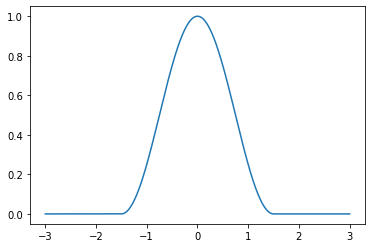

In [3]:
# Inside se3cnn.point.radial.CosineBasisModel
import math
import matplotlib.pyplot as plt
%matplotlib inline

max_radius = 3.0
number_of_basis = 3
radii = torch.linspace(0, max_radius, steps=number_of_basis)
step = radii[1] - radii[0]
basis = lambda x: x.div(step).add(1).relu().sub(2).neg().relu().add(1).mul(math.pi / 2).cos().pow(2)

x = torch.linspace(-max_radius, max_radius, 1000)
plt.plot(x, basis(x))

## Using functools.partial to set up classes
[Mario Geiger](https://mariogeiger.ch/) is the [BDFL](https://en.wikipedia.org/wiki/Benevolent_dictator_for_life) of `se3cnn`. `functools.partial` is Mario's favorite python function so we'll use it to define our radial function, kernel, convolution, and layers.

We are going to define `RadialModel` by specifying every single argument of `CosineBasisModel` using `functools.partial` EXCEPT out_dim which will be passed later. The `CosineBasisModel` will then have a `radial_layer=2` layer fully connected neural network with hidden dimention `h=100` applied to the basis functions vectors.

$$R_{c}(r_{ij}) = W_{ch} \sigma(W_{hb} B_b(r_{ij}))$$

where $b$ is the number of basis funcitons and $c$ is unintuitively the number of "paths" -- the number of valid combinations of $L_{input}$, $L_{filter}$, and $L_{output}$.

In [4]:
# se3cnn has operations for point sets and for 3D images. We will be using points.
import se3cnn.point
import se3cnn.point.radial
from functools import partial
from se3cnn.non_linearities import rescaled_act

# We are going to define RadialModel by specifying every single argument
# of CosineBasisModel EXCEPT out_dim which will be passed later
radial_layers = 2
sp = rescaled_act.Softplus(beta=5)
RadialModel = partial(se3cnn.point.radial.CosineBasisModel, max_radius=max_radius,
                      number_of_basis=number_of_basis, h=100,
                      L=radial_layers, act=sp)

## Setting up the kernel
Now we define the kernel or filter function by passing `RadialModel` in yet another call to `partial`. This time we are specifying all arguements to `Kernel` EXCEPT `Rs_in` and `Rs_out`, which again will be passed later.

One of the arguements to `Kernel` is `sh` which specifies which spherical harmonics to use. In the vast majority of cases, this should be set to the default `None` which use `se3cnn.SO3.spherical_harmonics_xyz`. 

### ...but just in case...
If you need to backpropogate to your input geometry, then you must use `se3cnn.SO3.spherical_harmonics_xyz_backwardable`. This should only be used for low $L$ as (for the current implementation) gradients become unstable for high $L$.

In [5]:
import se3cnn.point.kernel
sh = None
K = partial(se3cnn.point.kernel.Kernel, RadialModel=RadialModel, sh=sh)

## And finally we define our convolution

In [6]:
import se3cnn.point.operations

# If we wish to pass the convolution to a layer definition
C = partial(se3cnn.point.operations.Convolution, K)

# Or alternatively, if we want to use the convolution directly,
# we need to specify the `Rs` of the input and output
Rs_in = [(2, 0)]
Rs_out = [(4, 0), (4, 1), (4, 2)]
convolution = se3cnn.point.operations.Convolution(K, Rs_in, Rs_out) 

## Nonlinearities
There are two main nonlinearities that we use in `se3cnn`.

`se3cnn.non_linearities.norm_activation.NormActivation` applies a nonlinearity to the norm of each representation vector (to each copy of each $L$ in `Rs`) and `se3cnn.non_linearities.gated_block.GatedBlock` applies a nonlinearity by gating each $L > 0$ channel with an added scalar channel.

In [7]:
import se3cnn.non_linearities as nl
from se3cnn.non_linearities import rescaled_act

gated_block = nl.gated_block.GatedBlock(Rs_in, Rs_out, sp, rescaled_act.sigmoid, C)

dimensionalities = [2 * L + 1 for mult, L in Rs_out for _ in range(mult)]
norm_activation = nl.norm_activation.NormActivation(dimensionalities, rescaled_act.sigmoid, rescaled_act.sigmoid)